# MultiNest sampling

This example demonstrates how to use MultiNest sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

[1] "MultiNest: an efficient and robust Bayesian inference tool for cosmology and particle physics."
Feroz, F., M. P. Hobson, and M. Bridges. Monthly Notices of the Royal Astronomical Society 398.4 (2009): 1601-1614.

MultiNest works similarly to [ellipsoidal nested sampling](nested-ellipsoidal-sampling.ipynb) by proposing points using the prior but constraining the proposals such that they lie within ellipsoids of known high density. A key difference is that MultiNest uses (potentially) many ellipsoids to generate proposals, unlike ellipsoidal nested sampling, which uses only a single ellipsoid.

## Ellipsoids and ellipsoid trees

We illustrate this using the `Ellipsoid()` and `EllipsoidTree()` classes in PINTS. Whilst users do not need these to perform inference, we use them here to visualise the ellipses generated by fitting to two-dimensional data.

We first generate some sample data which we'll fit bounding ellipses to.

In [1]:
import os
os.chdir("../..")
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

We'll first draw some data from the [AnnulusLogPDF](../toy/http://localhost:8888/notebooks/pints/examples/toy/distribution-annulus.ipynb) example. Note that the ellipsoid tree methods work only within the unit cube, so we transform all points to lie within the [0,1]^2 range.

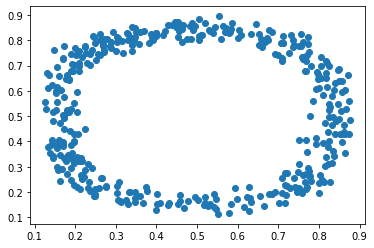

In [2]:
n = 400
log_pdf = pints.toy.AnnulusLogPDF()
draws = log_pdf.sample(400)
gaussian = pints.MultivariateGaussianLogPrior([0, 0], [[100, 0], [0, 100]])
draws = [gaussian.convert_to_unit_cube(x) for x in draws]
draws = np.vstack(draws)

plt.scatter(draws[:, 0], draws[:, 1])
plt.show()

Now we'll fit an ellipsoid tree to the data, which provides an ellipsoidal decomposition of the domain covered by the sample draws.

In [3]:
from pints._nested.__init__ import Ellipsoid
from pints._nested._multinest import EllipsoidTree

iteration = 600 # this number can be ignored for understanding this method for now
ellipsoid_tree = EllipsoidTree(draws, iteration)

Now plotting the ellipsoids (here, because the domain is 2D, these are actually ellipses) resultant from the spatial decomposition.

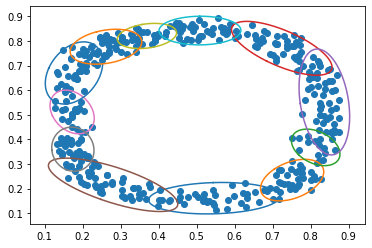

In [4]:
def plot_2d_ellipsoid(ellipsoid):
    A = ellipsoid.weight_matrix()
    c = ellipsoid.centroid()

    U, D, V = np.linalg.svd(A)

    # major and minor axes
    a = 1 / np.sqrt(D[0])
    b = 1 / np.sqrt(D[1])

    # generate x and y
    theta = np.linspace(0, 2 * np.pi, 1000)
    state_1 = a * np.cos(theta)
    state_2 = b * np.sin(theta)
    state = np.vstack((state_1, state_2))
    z = np.matmul(V, state)
    x = z[0, :] + c[0]
    y = z[1, :] + c[1]

    plt.plot(x, y)

def plot_2d_ellipsoid_tree_leaves(ellipsoid_tree):
    ellipsoids = ellipsoid_tree.leaf_ellipsoids()
    for ellipsoid in ellipsoids:
        plot_2d_ellipsoid(ellipsoid)
        
plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.scatter(draws[:, 0], draws[:, 1])
plt.show()

This ellipsoidal decomposition in stochastic: each replicate can yield a different decomposition.

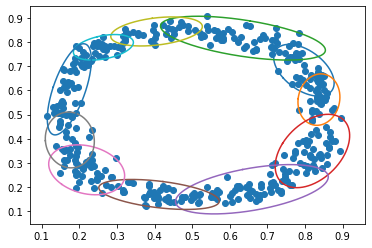

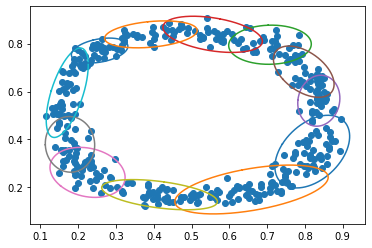

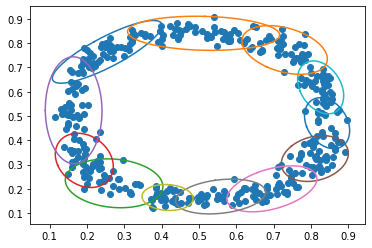

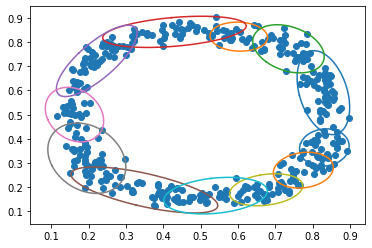

In [5]:
nreps = 4
for i in range(nreps):
    ellipsoid_tree = EllipsoidTree(draws, iteration)

    plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
    plt.scatter(draws[:, 0], draws[:, 1])
    plt.show()

In MultiNest, this ellipsoidal decomposition would be used to generate proposals which have an improved change of being accepted as part of a nested sampling algorithm. In PINTS' implementation of the ellipsoidal tree, we can sample uniformly within these ellipsoid set. This accounts for the overlap in the ellipses to ensure uniform sampling within the set.

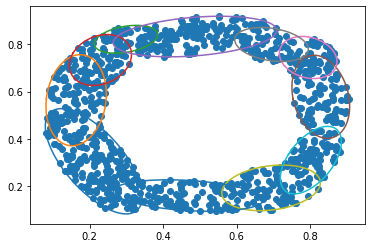

In [6]:
test_draws = ellipsoid_tree.sample_leaf_ellipsoids(1000)
test_draws = np.vstack(test_draws)

plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.scatter(test_draws[:, 0], test_draws[:, 1])
plt.show()

# Inference for the egg box problem

We now illustrate inference for the [egg box problem](distribution-simple-egg-box.ipynb): this problem is highly multimodal and causes issues for MCMC methods. Here, for ease of visualisation and to further separate the modes, we transform the dimensions.

In [13]:
class ExampleToy(pints.LogPDF):
    def __init__(self, sigma, r):
        self._sigma = sigma
        self._r = r
        self._log_toy = pints.toy.SimpleEggBoxLogPDF(self._sigma, self._r)

    def __call__(self, x):
        x1 = np.copy(x)
        x1[0] = -15 + 30 * x[0]
        x1[1] = -15 + 30 * x[1]
        return self._log_toy(x1)

    def n_parameters(self):
        return 2

log_pdf = ExampleToy(2, 4)
log_prior = pints.UniformLogPrior(
    [0.0, 0.0],
    [1.0, 1.0])

We set up the MultiNest sampler.

In [14]:
controller = pints.NestedController(log_pdf, log_prior, method=pints.MultinestSampler)

# Set number of iterations
controller.set_iterations(2000)

# Set the number of posterior samples to generate
controller.set_n_posterior_samples(500)

# Set threshold for updating ellipsoids as sampling runs
controller.sampler().set_f_s_threshold(1.1)

We run the sampler: note that the ellipsoid tree may be updated as the sampler runs, resulting in differing numbers of ellipsoids in the decomposition over time.

In [15]:
samples = controller.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 2000
Total number of posterior samples: 500
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.1 -inf          1               0             
0     181     0:00.1 -inf          1               0             
0     201     0:00.1 -inf          1               0             
0     221     0

We can plot the samples over the target density, and the draws appear to be a reasonable fit to the underlying density.

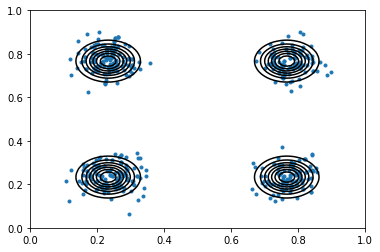

In [16]:
# Contour plot of pdf
levels = np.linspace(-100, 0, 20)
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = [[np.exp(log_pdf([i, j])) for i in x] for j in y]

plt.figure()
plt.contour(X, Y, Z, colors='k')
plt.scatter(samples[:, 0], samples[:, 1], marker='.')
plt.show()

Throughout sampling, the number of ellipsoids in the decomposition can vary. We can, however, visualise the final decomposition used to draw sample points: note that, these ellipsoids will likely be smaller than the distribution of draws near the end of a sample run.

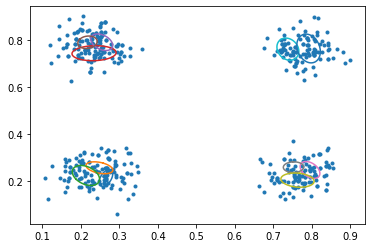

In [17]:
et = controller.sampler().ellipsoid_tree()
plot_2d_ellipsoid_tree_leaves(et)
draws = [log_prior.convert_to_unit_cube(x) for x in samples]
draws = np.vstack(draws)

plt.scatter(draws[:, 0], draws[:, 1], marker='.')
plt.show()

We can print the effective sample size...

In [22]:
print('effective sample size = ' + str(controller.effective_sample_size()))

effective sample size = 1330.870531219578


...and print our estimate of the marginal likelihood.

In [23]:
print('marginal log-likelihood = ' + str(controller.marginal_log_likelihood())
      + ' ± ' + str(controller.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -5.354985027132036 ± 0.05784529426426677


## ODE inference for logistic model

In [5]:
model = toy.LogisticModel()

# Create some toy data
times = np.linspace(0, 1000, 50)
real_parameters = np.array([0.015, 500])
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.014, 480],
    [0.016, 520]
)

In [6]:
# Run sampling on the noisy data
controller = pints.NestedController(log_likelihood, log_prior, method=pints.MultinestSampler)

# Set number of iterations
controller.set_iterations(3000)

# Set the number of posterior samples to generate
controller.set_n_posterior_samples(1000)

# Set threshold for updating ellipsoids as sampling runs
controller.sampler().set_f_s_threshold(1.01)

samples = controller.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 3000
Total number of posterior samples: 1000
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.0 -inf          1               0             
0     181     0:00.0 -inf          1               0             
0     201     0:00.0 -inf          1               0             
0     221     

Convergence obtained with Delta_z = -0.49972833813131956
Done!


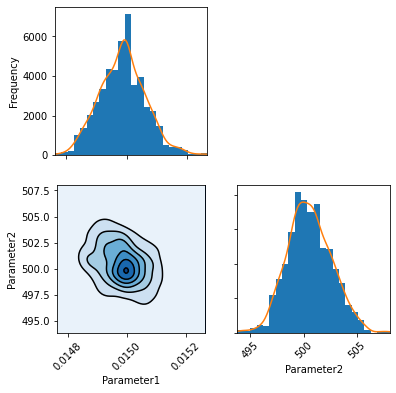

In [7]:
import pints.plot

pints.plot.pairwise(samples, kde=True)
plt.show()

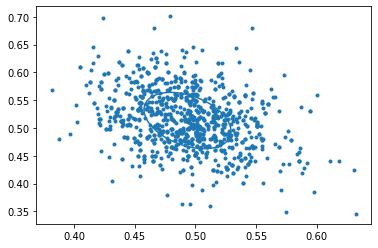

In [8]:
et = controller.sampler().ellipsoid_tree()
plot_2d_ellipsoid_tree_leaves(et)
draws = [log_prior.convert_to_unit_cube(x) for x in samples]
draws = np.vstack(draws)

plt.scatter(draws[:, 0], draws[:, 1], marker='.')
plt.show()

## Goodwin oscillator

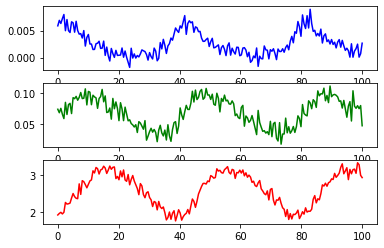

In [8]:
model = pints.toy.GoodwinOscillatorModel()
real_parameters = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(real_parameters, times)

noise1 = 0.001
noise2 = 0.01
noise3 = 0.1
noisy_values = np.array(values, copy=True)
noisy_values[:, 0] += np.random.normal(0, noise1, len(times))
noisy_values[:, 1] += np.random.normal(0, noise2, len(times))
noisy_values[:, 2] += np.random.normal(0, noise3, len(times))

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(times, noisy_values[:, 0], 'b')
plt.subplot(3, 1, 2)
plt.plot(times, noisy_values[:, 1], 'g')
plt.subplot(3, 1, 3)
plt.plot(times, noisy_values[:, 2], 'r')
plt.show()

In [9]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior([1, 1, 0.01, 0.01, 0.01], [10, 10, 1, 1, 1])
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, [noise1, noise2, noise3])
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
controller = pints.NestedController(log_likelihood, log_prior, method=pints.MultinestSampler)
# Set number of iterations
controller.set_iterations(20000)

# Set the number of posterior samples to generate
controller.set_n_posterior_samples(1000)

# Set threshold for updating ellipsoids as sampling runs
controller.sampler().set_f_s_threshold(1.01)

samples = controller.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 20000
Total number of posterior samples: 1000
Iter. Eval.  Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1        0:00.0 -inf          1               0             
0     2        0:00.0 -inf          1               0             
0     21       0:00.3 -inf          1               0             
0     41       0:00.7 -inf          1               0             
0     61       0:01.0 -inf          1               0             
0     81       0:01.2 -inf          1               0             
0     101      0:01.6 -inf          1               0             
0     121      0:01.9 -inf          1               0             
0     141      0:02.2 -inf          1               0             
0     161      0:02.4 -inf          1               0             
0     181      0:02.7 -inf          1               0             
0     201      0:03.1 -inf          1               0             


1980  4697     0:47.6 -3731.928811  0.460786595299  12            
2000  4755     0:48.3 -3687.2279    0.459242250287  12            
2020  4844     0:48.8 -3657.374834  0.454545455     12            
2040  4913     0:49.2 -3596.07898   0.452027476     12            
2060  4991     0:49.6 -3535.784031  0.448703986     12            
2080  5108     0:50.2 -3474.1576    0.441801189     12            
2100  5214     0:52.3 -3444.214552  0.436227669     12            
2120  5417     0:53.3 -3384.565007  0.422563285     12            
2140  5529     0:53.9 -3330.949999  0.417235329     12            
2160  5685     0:54.7 -3288.318285  0.408703879     12            
2180  5828     0:55.4 -3241.135173  0.401621223     12            
2200  6014     0:56.5 -3207.052415  0.391877449     12            
2220  6150     0:57.2 -3165.296506  0.386086957     12            
2240  6276     0:57.9 -3138.89637   0.381211709     12            
2260  6413     0:58.6 -3108.187235  0.37585232      12        

/Volumes/Samsung1.5TB/Github/pints/pints/_nested/__init__.py:971: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(r)


2600  14959    1:52.0 -2600.243161  0.178583693935  14            
2620  15226    1:53.4 -2571.258621  0.176716579     14            
2640  15430    1:54.4 -2552.493391  0.175648703     14            
2660  15731    1:56.0 -2537.038138  0.173504664     14            
2680  16145    1:58.1 -2505.709095  0.170212766     14            
2700  16364    2:00.3 -2485.424704  0.169130544     13            
2720  16481    2:00.9 -2461.744187  0.16914371      13            
2740  16656    2:01.8 -2438.041524  0.16855315      13            
2760  16821    2:02.6 -2420.942884  0.168077462     13            
2780  16982    2:03.4 -2405.43916   0.16765167      13            
2800  17206    2:06.1 -2392.238974  0.166607164     12            
2820  17380    2:07.0 -2370.489944  0.166077739     12            
2840  17518    2:07.7 -2357.396004  0.165907232     12            
2860  17741    2:08.7 -2340.74488   0.164927051     12            
2880  17937    2:09.7 -2450.985141  0.164224212     12        

5060  41385    4:45.4 -546.1092244  0.123459802     13            
5080  41537    4:46.3 -528.9512546  0.123489802     13            
5100  41639    4:47.6 -517.0052846  0.123669342     12            
5120  41761    4:48.3 -510.4317365  0.12378811      12            
5140  41866    4:48.9 -498.932175   0.123956977     12            
5160  41973    4:49.6 -487.0961027  0.124119019556  12            
5180  42118    4:50.4 -472.3779278  0.124167026     12            
5200  42220    4:52.8 -455.4940053  0.12434242      12            
5220  42301    4:53.3 -444.8433907  0.124579366     12            
5240  42394    4:53.9 -432.0467819  0.12477973      12            
5260  42493    4:54.5 -422.4608353  0.124961395     12            
5280  42561    4:54.9 -412.7778914  0.125234221     12            
5300  42674    4:55.9 -406.4148648  0.125372569428  11            
5320  42799    4:56.6 -397.7257791  0.125474657     11            
5340  42874    4:57.1 -386.8214193  0.125723972     11        

7520  50551    5:55.6 -38.04397868  0.14994716      12            
7540  50637    5:56.1 -37.22101036  0.15008858      12            
7560  50708    5:56.6 -36.43382746  0.15027431      12            
7580  50775    5:57.0 -35.66148487  0.150471464     12            
7600  50845    5:57.7 -36.31211105  0.15065913371   11            
7620  50953    5:58.4 -35.55309743  0.150732894     11            
7640  51029    5:58.8 -34.72147684  0.150901657153  11            
7660  51089    5:59.2 -36.01359451  0.151117599     11            
7680  51177    5:59.7 -35.21929114  0.151249582     11            
7700  51288    6:00.7 -34.48584554  0.151312687     12            
7720  51324    6:00.9 -33.65034336  0.15159846      12            
7740  51384    6:01.3 -32.91425339  0.151812333281  12            
7760  51423    6:01.6 -32.09883201  0.152088274     12            
7780  51464    6:01.8 -31.40067382  0.152357825     12            
7800  51517    6:02.8 -30.68628157  0.152591114502  12        

9980  56368    6:39.3 -2.691050938  0.178316181     12            
10000 56408    6:39.8 -2.604151109  0.178545922     1             
10020 56463    6:40.1 -2.518789789  0.178727503     1             
10040 56516    6:40.5 -2.435493585  0.178915104     1             
10060 56592    6:40.9 -2.353708627  0.179029043     1             
10080 56650    6:41.3 -2.272869824  0.1792          1             
10100 56716    6:41.7 -2.193819697  0.179345124     1             
10120 56768    6:42.0 -2.116557468  0.179534488     1             
10140 56826    6:42.4 -2.041502345  0.179704392     1             
10160 56877    6:42.7 -1.968115712  0.179896241     1             
10180 56921    6:43.0 -1.89637981   0.180110048     1             
10200 56993    6:43.4 -1.913904489  0.180234304596  1             
10220 57031    6:43.7 -1.845168984  0.180466529     1             
10240 57075    6:43.9 -1.777937653  0.180679312     1             
10260 57126    6:44.2 -1.712077001  0.180869443     1         

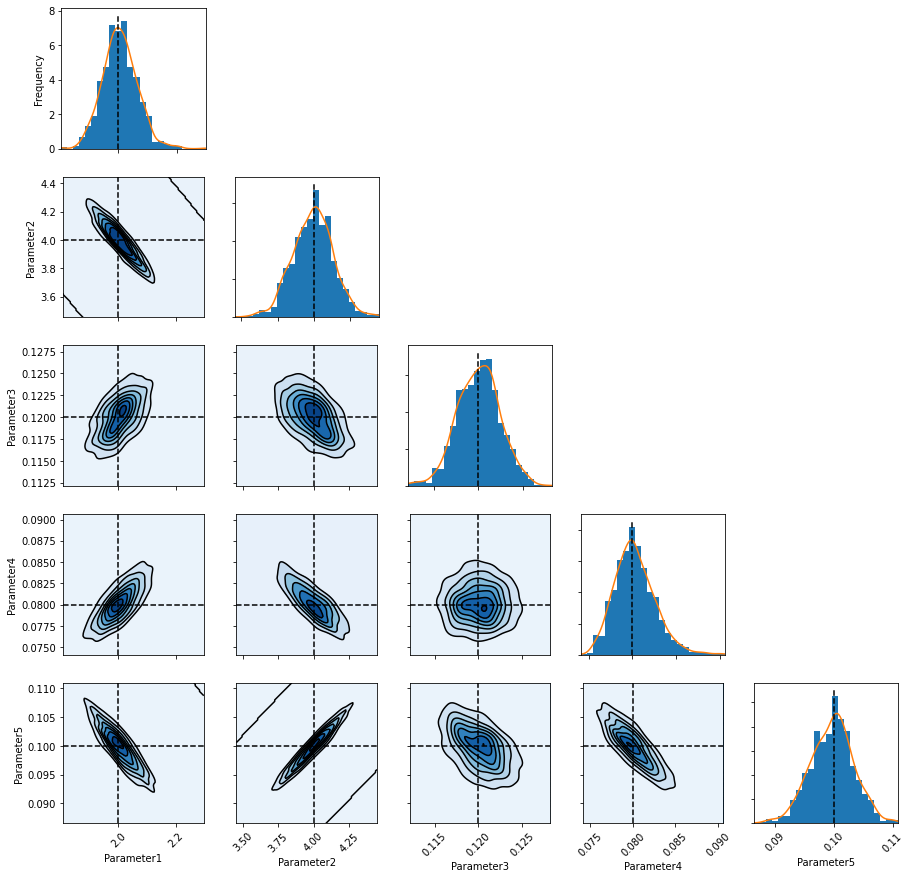

In [12]:
import pints.plot

pints.plot.pairwise(samples, kde=True, ref_parameters=real_parameters)
plt.show()